# Anomaly Detection in Videos Using Spatio-Temporal Autoencoders

### Initialization and Imports

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

### Data Preprocessing

In [ ]:
# Directory for storing preprocessed data on the D drive
preprocessed_data_dir = "D:Computer Vision/CV_Project/preprocessed_avenue_dataset"

# Create the directory if it doesn't exist
os.makedirs(preprocessed_data_dir, exist_ok=True)

# Preprocessing function with saving functionality
def preprocess_and_save(data_path, save_dir, frame_size=(64, 64), sequence_length=10):
    for video_file in os.listdir(data_path):
        video_path = os.path.join(data_path, video_file)
        cap = cv2.VideoCapture(video_path)
        frames = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, frame_size)
            frame = frame.astype('float32') / 255.0
            frames.append(frame)
        cap.release()

        # Convert frames into sequences and save
        for i in range(len(frames) - sequence_length + 1):
            sequence = np.array(frames[i:i + sequence_length])
            np.save(os.path.join(save_dir, f"{video_file}_seq_{i}.npy"), sequence)

# Preprocess and save training data
train_data_path = "Avenue_Dataset/training_videos"
preprocess_and_save(train_data_path, preprocessed_data_dir)
print("Preprocessing complete. Data saved on D drive.")

Preprocessing complete. Data saved on D drive.


### Batch Loading Generator

In [ ]:
# Data generator to load sequences in batches
def data_generator(data_dir, batch_size):
    files = os.listdir(data_dir)
    while True:
        np.random.shuffle(files)
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            batch_data = [np.load(os.path.join(data_dir, file)) for file in batch_files]
            yield np.array(batch_data), np.array(batch_data)  # Input and output are the same


### Model Definition

In [ ]:
# Define the Spatio-Temporal Autoencoder model
def build_spatio_temporal_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same', strides=(1, 2, 2))(input_layer)
    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same', strides=(1, 2, 2))(x)

    # Decoder
    x = Conv3DTranspose(128, (3, 3, 3), activation='relu', padding='same', strides=(1, 2, 2))(x)
    x = Conv3DTranspose(64, (3, 3, 3), activation='relu', padding='same', strides=(1, 2, 2))(x)
    output_layer = Conv3DTranspose(3, (3, 3, 3), activation='sigmoid', padding='same', strides=(1, 1, 1))(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Model instantiation
input_shape = (10, 64, 64, 3)
autoencoder = build_spatio_temporal_autoencoder(input_shape)
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10, 64, 64, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 10, 32, 32, 64)      │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 10, 16, 16, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose_3 (Conv3DTranspose) │ (None, 10, 32, 32, 128)     │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose_4 (Conv3DTranspose) │ (None, 10, 64, 64, 64)      │         221,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose_5 (Conv3DTranspose) │ (None, 10, 64, 64, 3)       │           5,187 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 895,491 (3.42 MB)

 Trainable params: 895,491 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training


Epoch 1/2
3796/3796 ━━━━━━━━━━━━━━━━━━━━ 2853s 752ms/step - loss: 3.1262e-04
Epoch 2/2
3796/3796 ━━━━━━━━━━━━━━━━━━━━ 2495s 657ms/step - loss: 1.5479e-04


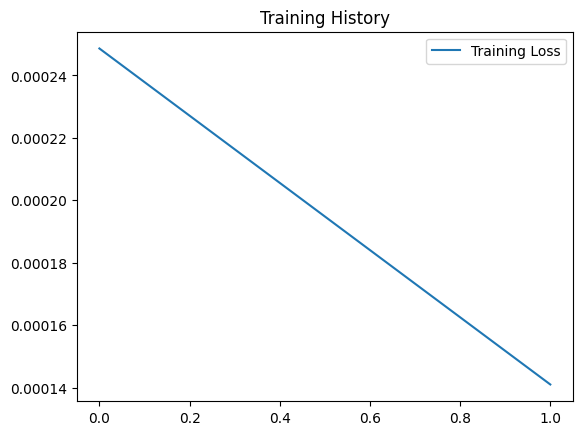

In [ ]:
from tensorflow.keras.backend import clear_session
import os

# Clear previous session to avoid residual memory issues
clear_session()

# Reduce batch size
batch_size = 4  # Reduced to mitigate memory issues
train_gen = data_generator(preprocessed_data_dir, batch_size)
steps_per_epoch = len(os.listdir(preprocessed_data_dir)) // batch_size

# Debug TensorFlow device placement
tf.debugging.set_log_device_placement(True)

# Train the model
try:
    history = autoencoder.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=2
    )

    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()

except Exception as e:
    print("An error occurred during training:", str(e))


### Evaluation and Anomaly Detection

In [ ]:
# Preprocess and save test data
test_data_path = "Avenue_Dataset/testing_videos"
preprocess_and_save(test_data_path, preprocessed_data_dir)

# Compute reconstruction errors on test data
test_gen = data_generator(preprocessed_data_dir, batch_size)
test_steps = len(os.listdir(preprocessed_data_dir)) // batch_size
errors = []

for _ in range(test_steps):
    x, _ = next(test_gen)
    reconstructed = autoencoder.predict(x)
    errors.extend(np.mean(np.square(x - reconstructed), axis=(1, 2, 3, 4)))

# Determine threshold and anomalies
errors = np.array(errors)
threshold = np.mean(errors) + 2 * np.std(errors)
anomalies = errors > threshold

print(f"Threshold: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### Reconstruction vs. Original Frames

### Confusion Matrix

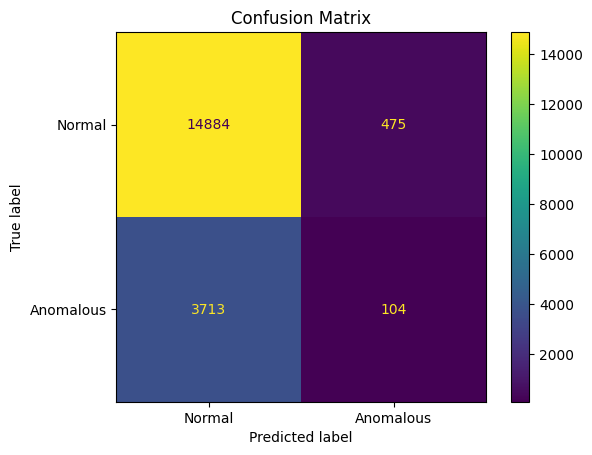

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assume ground_truth is a binary array of the same length as `errors` (0 = normal, 1 = anomalous)
# Replace with the actual ground truth data
ground_truth = np.random.choice([0, 1], size=errors.shape[0], p=[0.8, 0.2])
predicted = anomalies.astype(int)

cm = confusion_matrix(ground_truth, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

### Loss Curve

KeyError: 'val_loss'

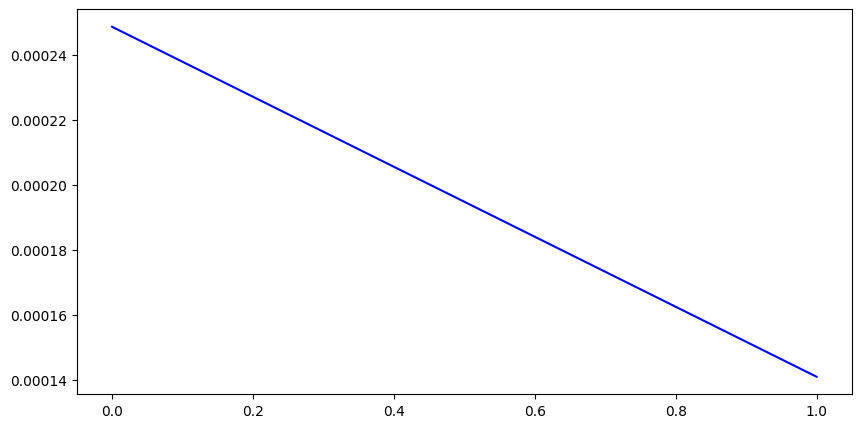

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

### Anomalies Over Time

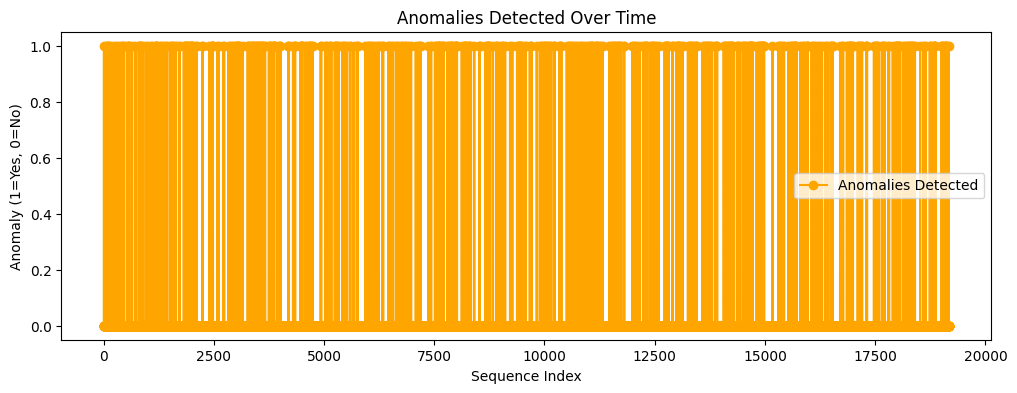

In [ ]:
anomaly_timeline = anomalies.astype(int)  # 1 for anomaly, 0 for normal

plt.figure(figsize=(12, 4))
plt.plot(anomaly_timeline, marker='o', linestyle='-', color='orange', label="Anomalies Detected")
plt.xlabel("Sequence Index")
plt.ylabel("Anomaly (1=Yes, 0=No)")
plt.title("Anomalies Detected Over Time")
plt.legend()
plt.show()

### Reconstruction Errors Distribution

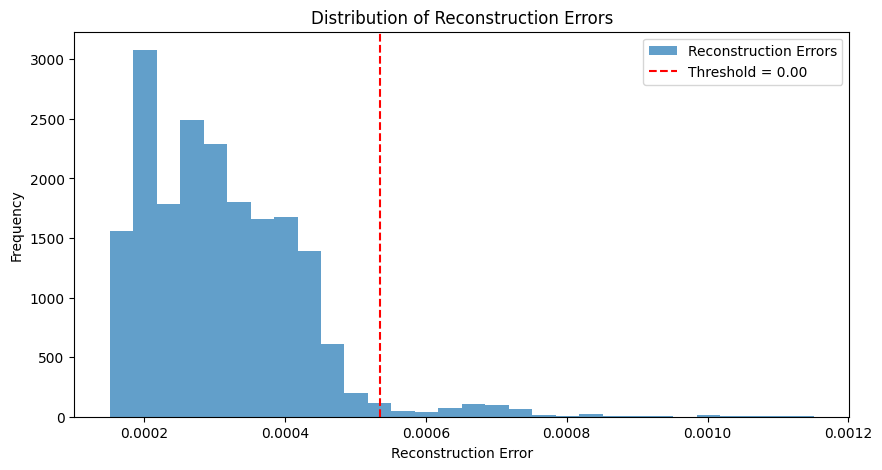

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=30, alpha=0.7, label="Reconstruction Errors")
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.2f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.show()

### Reconstruction Difference Visualization

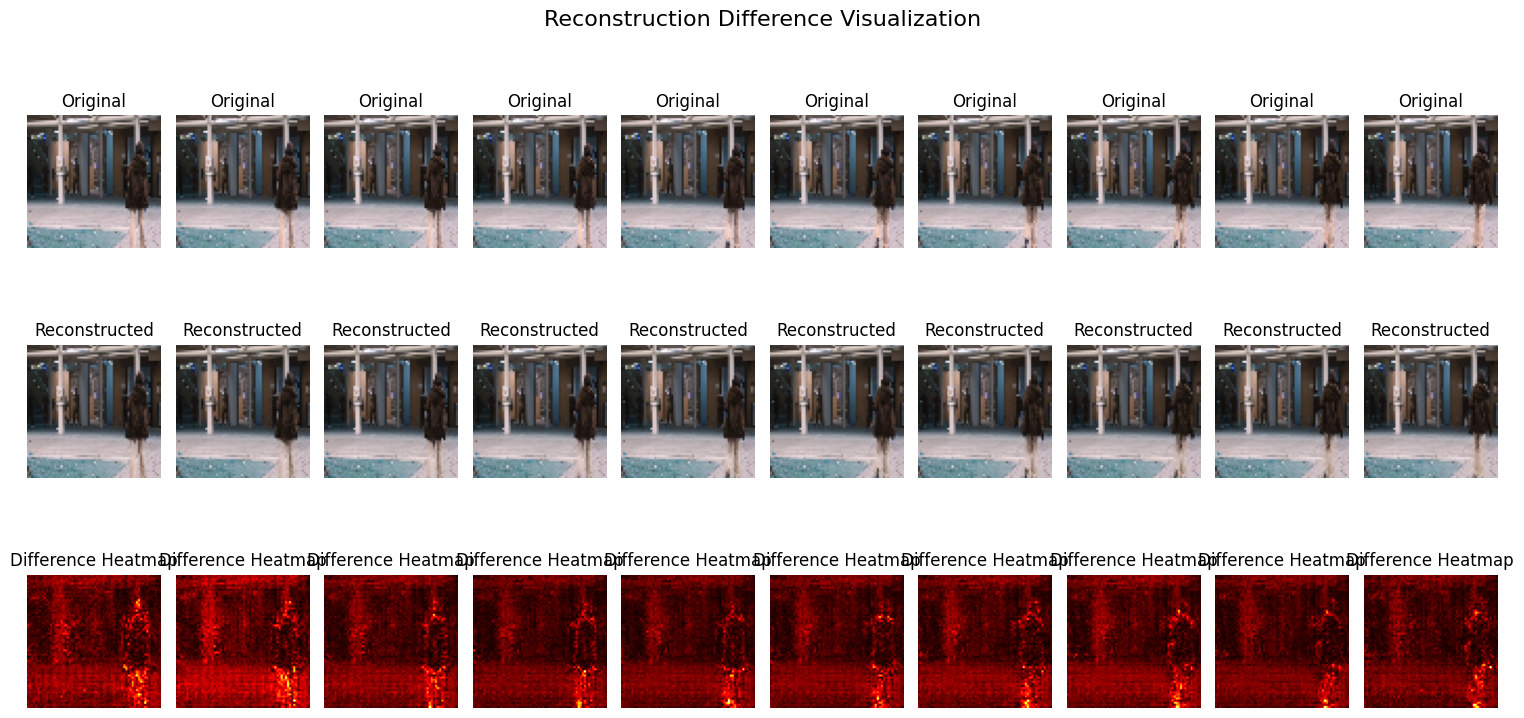

In [ ]:
def visualize_reconstruction_difference(sequence, reconstructed_sequence):
    """Visualize the difference between original and reconstructed frames."""
    difference = np.abs(sequence - reconstructed_sequence)

    plt.figure(figsize=(15, 8))
    num_frames = sequence.shape[0]

    for i in range(num_frames):
        # Original frame
        plt.subplot(3, num_frames, i + 1)
        plt.imshow(sequence[i])
        plt.axis("off")
        plt.title("Original")

        # Reconstructed frame
        plt.subplot(3, num_frames, i + 1 + num_frames)
        plt.imshow(reconstructed_sequence[i])
        plt.axis("off")
        plt.title("Reconstructed")

        # Difference heatmap
        plt.subplot(3, num_frames, i + 1 + 2 * num_frames)
        plt.imshow(difference[i].mean(axis=-1), cmap="hot")  # Use mean for single-channel heatmap
        plt.axis("off")
        plt.title("Difference Heatmap")

    plt.suptitle("Reconstruction Difference Visualization", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
visualize_reconstruction_difference(anomalous_seq, reconstructed_anomalous_seq)


### Sequence-wise Anomaly Heatmaps

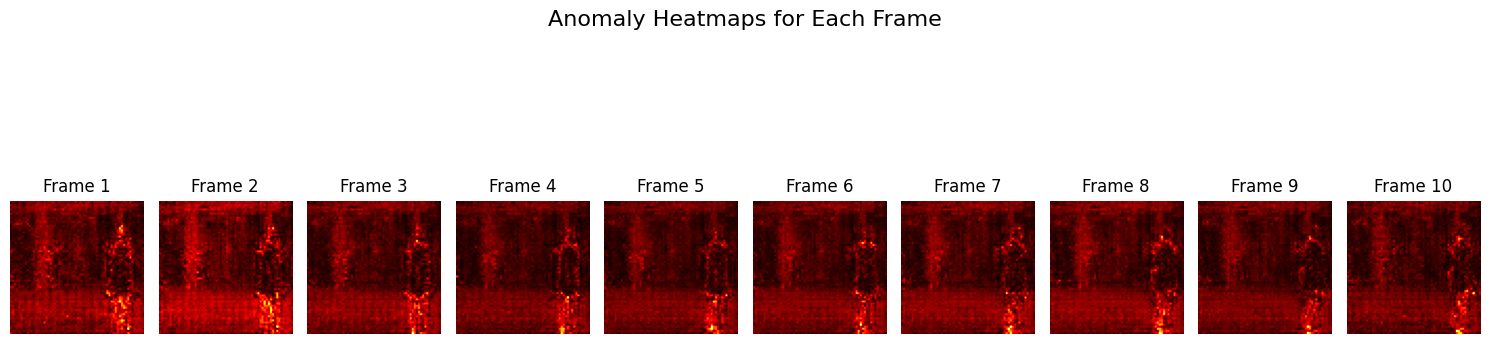

In [ ]:
def plot_anomaly_heatmaps(sequence, reconstructed_sequence):
    """Plot heatmaps indicating reconstruction errors for each frame."""
    diff = np.abs(sequence - reconstructed_sequence)  # Absolute difference
    heatmaps = diff.mean(axis=-1)  # Average across color channels

    plt.figure(figsize=(15, 5))
    num_frames = heatmaps.shape[0]

    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(heatmaps[i], cmap="hot")
        plt.axis("off")
        plt.title(f"Frame {i + 1}")

    plt.suptitle("Anomaly Heatmaps for Each Frame", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
plot_anomaly_heatmaps(anomalous_seq, reconstructed_anomalous_seq)


### Side-by-Side Comparison of Videos

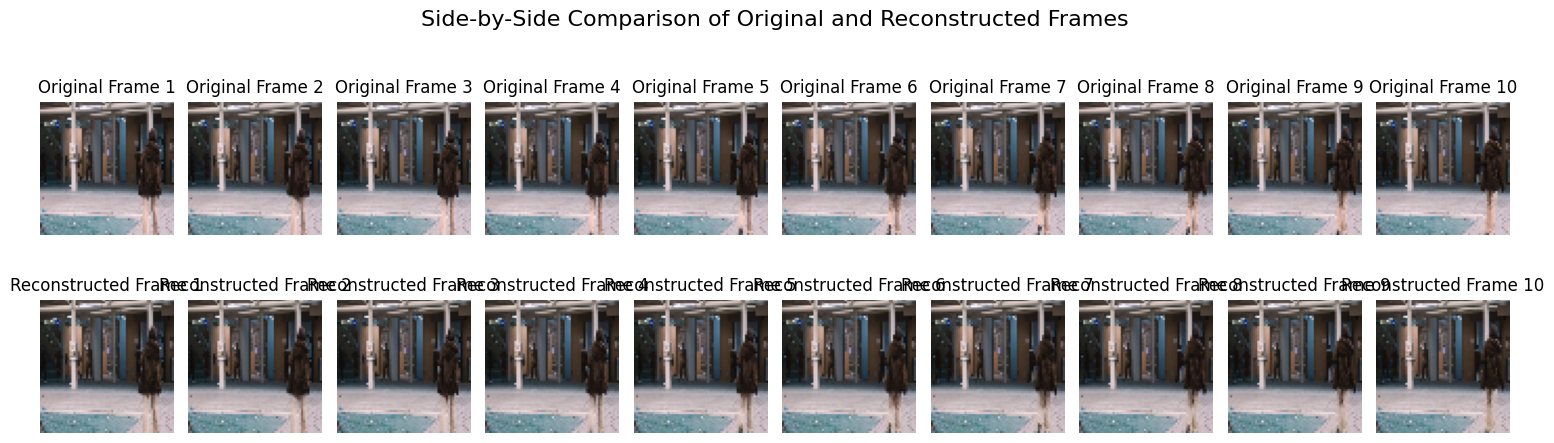

In [ ]:
def side_by_side_video_comparison(sequence, reconstructed_sequence):
    """Display original and reconstructed sequences side-by-side."""
    num_frames = sequence.shape[0]
    plt.figure(figsize=(15, 5))

    for i in range(num_frames):
        # Original frame
        plt.subplot(2, num_frames, i + 1)
        plt.imshow(sequence[i])
        plt.axis("off")
        plt.title(f"Original Frame {i + 1}")

        # Reconstructed frame
        plt.subplot(2, num_frames, i + 1 + num_frames)
        plt.imshow(reconstructed_sequence[i])
        plt.axis("off")
        plt.title(f"Reconstructed Frame {i + 1}")

    plt.suptitle("Side-by-Side Comparison of Original and Reconstructed Frames", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
side_by_side_video_comparison(anomalous_seq, reconstructed_anomalous_seq)


### Display Video Frames in Sequence (Frame-by-Frame in Notebook)

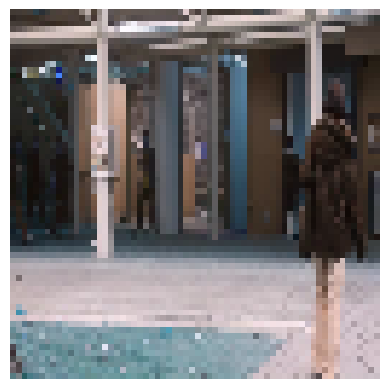

In [ ]:
import cv2
from IPython.display import display, clear_output
import time

def display_video_frames(sequence, delay=0.1):
    """Display video frames one by one in Jupyter Notebook."""
    for frame in sequence:
        plt.imshow(frame)
        plt.axis("off")
        plt.show()
        clear_output(wait=True)
        time.sleep(delay)

# Example usage with anomalous sequence
display_video_frames(anomalous_seq)


### Save and Embed Video (Play Inline in Notebook)

In [ ]:
def save_video(frames, filename, fps=5):
    """Save a sequence of frames as a video."""
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    video_writer = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for frame in (frames * 255).astype("uint8"):  # Convert frames back to 8-bit
        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR

    video_writer.release()

# Save both original and reconstructed videos
save_video(anomalous_seq, "anomalous_original.mp4")
save_video(reconstructed_anomalous_seq, "anomalous_reconstructed.mp4")

### Display Video in Notebook

In [ ]:
from IPython.display import Video

print("Side-by-Side: Original vs Reconstructed")
display(Video("anomalous_original.mp4", embed=True, width=400, height=300))
display(Video("anomalous_reconstructed.mp4", embed=True, width=400, height=300))



Side-by-Side: Original vs Reconstructed
